# Pylops - signal processing

### Author: M.Ravasi

In this notebook I will show how to use some of the linear operators for signal processing in *Pylops*.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp


from scipy.signal import fftconvolve
from scipy.sparse import csr_matrix, vstack
from scipy.linalg import lstsq, solve
from scipy.sparse.linalg import LinearOperator, cg, lsqr
from scipy import misc

from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.utils.seismicevents        import *
from pylops.basicoperators             import *
from pylops.signalprocessing           import *
from pylops.waveeqprocessing.mdd       import *

from pylops.optimization.leastsquares  import *
from pylops.optimization.sparsity  import *

# just for comparison
from Convolve1D_old import Convolve1D as Convolve1D_old
from Convolve2D_old import Convolve2D as Convolve2D_old

## FFT

We are now interested to apply the forward Fourier transform to a signal $d(t)$:

$$D(f) = \int d(t) e^{-j2\pi ft} dt = \mathscr{F} (d)$$

This operation can be discretized and performed by means of a linear operator

$$\mathbf{D}= \mathbf{F} \mathbf{d}$$

Similarly we would like to apply the inverse Fourier transform (that in this special case is equivalent to the adjoint of operator $\mathbf{F}$):

$$d(t) = \int D(f) e^{j2\pi ft} df = \mathscr{F}^{-1} (d) $$

which is 

$$\mathbf{d}= \mathbf{F}^H \mathbf{D}$$

Let's start by applying this operator to a 1d signal

Dot test passed, v^T(Opu)=-7.887308+9.889060i - u^T(Op^Tv)=-7.887308+9.889060i


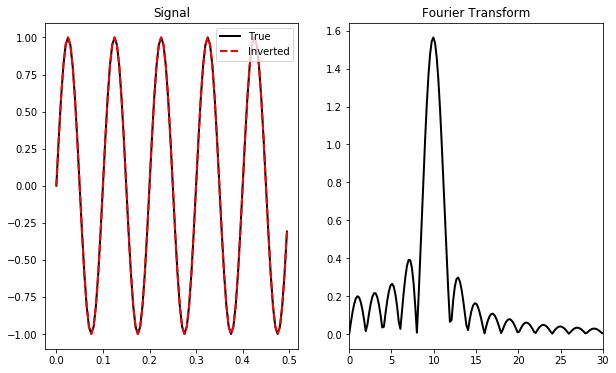

In [2]:
dt   = 0.005
nt   = 100
t    = np.arange(nt)*dt
f0   = 10
nfft = 2**10
d  = np.sin(2*np.pi*f0*t)

FFTop = FFT(dims=[nt], nfft=nfft, sampling=dt)
dottest(FFTop, nfft, nt, complexflag=3, verb=True)

D    = FFTop*d
#dinv = FFTop.H*D # adjoint is inverse for fft
dinv = FFTop / D

fig, axs = plt.subplots(1,2,figsize=(10,6))
axs[0].plot(t,d,    'k',  lw=2, label='True')
axs[0].plot(t,dinv,'--r',lw=2, label='Inverted')
axs[0].legend()
axs[0].set_title('Signal')
axs[1].plot(FFTop.f[:int(FFTop.nfft/2)], np.abs(D[:int(FFTop.nfft/2)]),'k',lw=2)
axs[1].set_title('Fourier Transform')
axs[1].set_xlim([0,3*f0]);

Let's look into the dot test, it works for real=Fase

In [3]:
nt=100
nfft=2**11
u=np.random.normal(0,1,nt)
v=np.random.normal(0,1,nfft)+1j*np.random.normal(0,1,nfft)
#v = np.sqrt(1. / nfft)*np.fft.fft(u, n=nfft)

y = np.sqrt(1. / nfft)*np.fft.fft(u, n=nfft)
x = np.sqrt(nfft)*np.fft.ifft(v)
x=x[:nt]

yy = np.vdot(y, v) # (Op  * u)' * v
xx = np.vdot(u, x) # u' * (Op' * v)

print(yy)
print(xx)
print(np.abs((yy-xx)/((yy+xx+1e-15)/2)))

(7.420147416100538+8.918968953446914j)
(7.420147416100541+8.918968953446909j)
5.135388505065392e-16


but it cannot work for real=False and both y and v are imag but u and x are real... anyways, if you have a chained operator with FFT and FFT.T with real=True the operator can pass the dottest (see MDC)

In [4]:
nt=100
nfft=2**11
u=np.random.normal(0,1,nt)
v=np.random.normal(0,1,nfft//2+1)+1j*np.random.normal(0,1,nfft//2+1)
v[0]=v[0]-1j*v[0].imag
v[-1]=v[-1]-1j*v[-1].imag

y = np.sqrt(1. / (nfft//2+1.))*np.fft.rfft(u, n=nfft)
x = np.sqrt(nfft//2+1.)*np.fft.irfft(v)
x=x[:nt]

yy = np.vdot(y, v) # (Op  * u)' * v
xx = np.vdot(u, x) # u' * (Op' * v)

print(yy)
print(xx)
print(np.abs((yy-xx)/((yy+xx+1e-15)/2)))

(18.10269319688593-5.667112047948996j)
17.984245104122376
0.310346134372983


We now apply a fast Fourier transform to a 2d signal (along one of the axis)

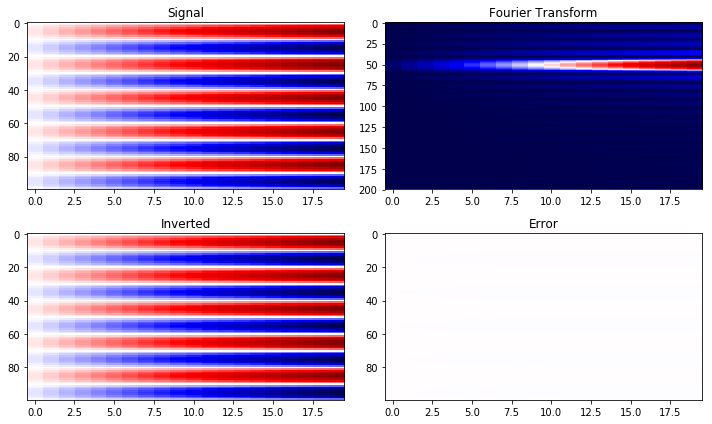

In [5]:
dt     = 0.005
nt,nx  = 100, 20
t      = np.arange(nt)*dt
f0     = 10
nfft   = 2**10
d      = np.outer(np.sin(2*np.pi*f0*t), np.arange(nx)+1)

FFTop = FFT(dims=[nt,nx], dir=0, nfft=nfft, sampling=dt)
dottest(FFTop, nfft*nx, nt*nx, complexflag=2)

D    = FFTop*d.flatten()
#dinv = FFTop.H*D # adjoint is inverse for fft
dinv = np.real(FFTop / D).reshape(nt,nx)

fig, axs = plt.subplots(2,2,figsize=(10,6))
axs[0][0].imshow(d, vmin=-20, vmax=20, cmap='seismic')
axs[0][0].set_title('Signal')
axs[0][0].axis('tight')
axs[0][1].imshow(np.abs(D.reshape(nfft,nx)[:200,:]), cmap='seismic')
axs[0][1].set_title('Fourier Transform')
axs[0][1].axis('tight')
axs[1][0].imshow(dinv, vmin=-20, vmax=20, cmap='seismic')
axs[1][0].set_title('Inverted')
axs[1][0].axis('tight')
axs[1][1].imshow(d-dinv, vmin=-20, vmax=20, cmap='seismic')
axs[1][1].set_title('Error')
axs[1][1].axis('tight')
fig.tight_layout();

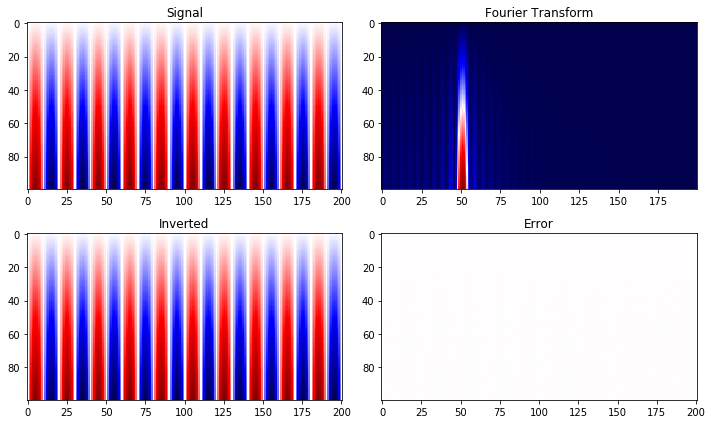

In [6]:
dx     = 0.005
nt,nx  = 100, 201
x      = np.arange(nx)*dx
f0     = 10
nfft   = 2**10
d      = np.outer(np.arange(nt)+1, np.sin(2*np.pi*f0*x))

FFTop = FFT(dims=[nt,nx], dir=1, nfft=nfft, sampling=dt)
dottest(FFTop, nt*nfft, nt*nx, complexflag=2)

D    = FFTop*d.flatten()
#dinv = FFTop.H*D # adjoint is inverse for fft
dinv, istop, itn, r1norm, r2norm = lsqr(FFTop, D, damp=1e-10, iter_lim=1000 ,show=0)[0:5]
dinv = np.real(dinv).reshape(nt,nx)

fig, axs = plt.subplots(2,2,figsize=(10,6))
axs[0][0].imshow(d, vmin=-100, vmax=100, cmap='seismic')
axs[0][0].set_title('Signal')
axs[0][0].axis('tight')
axs[0][1].imshow(np.abs(D.reshape(nt,nfft)[:,:200]), cmap='seismic')
axs[0][1].set_title('Fourier Transform')
axs[0][1].axis('tight')
axs[1][0].imshow(dinv, vmin=-100, vmax=100, cmap='seismic')
axs[1][0].set_title('Inverted')
axs[1][0].axis('tight')
axs[1][1].imshow(d-dinv, vmin=-100, vmax=100, cmap='seismic')
axs[1][1].set_title('Error')
axs[1][1].axis('tight')
fig.tight_layout()

And a 3d signal

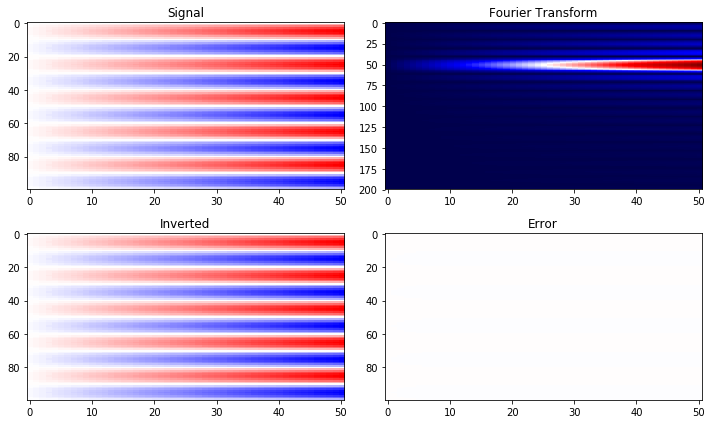

In [7]:
dt, dx, dy = 0.005, 5, 1
nt, nx, ny  = 100, 51, 6
t      = np.arange(nt)*dt
f0     = 10
nfft   = 2**10
d      = np.outer(np.sin(2*np.pi*f0*t), np.arange(nx)+1)
d      = np.tile(d[:,:,np.newaxis], [1,1,ny])

FFTop = FFT(dims=[nt,nx,ny], dir=0, nfft=nfft, sampling=dt)
dottest(FFTop, nfft*nx*ny, nt*nx*ny, complexflag=2)

D    = FFTop*d.flatten()
#dinv = FFTop.H*D # adjoint is inverse for fft
dinv, istop, itn, r1norm, r2norm = lsqr(FFTop, D, damp=1e-10, iter_lim=1000 ,show=0)[0:5]
dinv = np.real(dinv).reshape(nt,nx,ny)

fig, axs = plt.subplots(2,2,figsize=(10,6))
axs[0][0].imshow(d[:,:,ny//2], vmin=-100, vmax=100, cmap='seismic')
axs[0][0].set_title('Signal')
axs[0][0].axis('tight')
axs[0][1].imshow(np.abs(D.reshape(nfft,nx,ny)[:200,:,ny//2]), cmap='seismic')
axs[0][1].set_title('Fourier Transform')
axs[0][1].axis('tight')
axs[1][0].imshow(dinv[:,:,ny//2], vmin=-100, vmax=100, cmap='seismic')
axs[1][0].set_title('Inverted')
axs[1][0].axis('tight')
axs[1][1].imshow(d[:,:,ny//2]-dinv[:,:,ny//2], vmin=-100, vmax=100, cmap='seismic')
axs[1][1].set_title('Error')
axs[1][1].axis('tight')
fig.tight_layout()

Let's try now the fftw implementation

In [8]:
dt = 0.005
nt = 100
t = np.arange(nt)*dt
f0 = 10
nfft = 2**10
d = np.sin(2*np.pi*f0*t)

FFTop = FFT(dims=nt, nfft=nfft, sampling=dt)
D = FFTop*d
dadj = FFTop.H*D

FFTop1 = FFT(dims=nt, nfft=nfft, sampling=dt, engine='fftw')
D1 = FFTop1*d
d1adj = FFTop1.H*D

print(D-D1)
print(dadj-d1adj)
dottest(FFTop, nfft, nt, complexflag=1)
dottest(FFTop1, nfft, nt, complexflag=1)

[0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
[0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]


True

## FFT2

Similarly to the 1d Fourier transform, we can create an operator to apply 2d FFT to a signal $d(y,x)$:

$$D(k_y, k_x) = \int \int d(y,x) e^{-j2\pi k_y y}  e^{-j2\pi k_x x} dy dx $$

This operation can be discretized and performed by means of a linear operator

$$\mathbf{D}= \mathbf{F2} \mathbf{d}$$

Similarly we would like to apply the inverse Fourier transform (that in this special case is equivalent to the adjoint of operator $\mathbf{F}$):

$$d(y,x) = \int \int D(k_y, k_x) e^{j2\pi k_y y}   e^{j2\pi k_xx} dk_y dk_x $$

which is 

$$\mathbf{d}= \mathbf{F2}^H \mathbf{D}$$

Apply 2d Fourier transform to 2d data

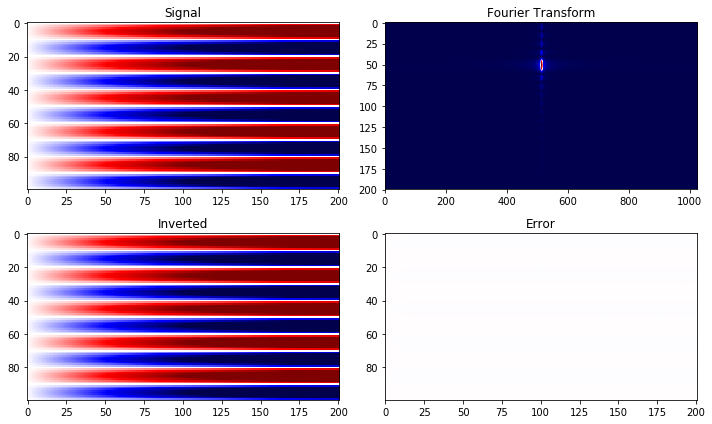

In [9]:
dt, dx = 0.005, 5
nt,nx  = 100, 201
t      = np.arange(nt)*dt
x      = np.arange(nx)*dx
f0     = 10
nfft   = 2**10
d      = np.outer(np.sin(2*np.pi*f0*t), np.arange(nx)+1)

FFTop = FFT2D(dims=[nt,nx], nffts=[nfft,nfft], sampling=[dt,dx])
dottest(FFTop, nfft*nfft, nt*nx, complexflag=2)

D    = FFTop*d.flatten()
#dinv = FFTop.H*D # adjoint is inverse for fft
dinv, istop, itn, r1norm, r2norm = lsqr(FFTop, D, damp=1e-10, iter_lim=1000 ,show=0)[0:5]
dinv = np.real(dinv).reshape(nt,nx)

fig, axs = plt.subplots(2,2,figsize=(10,6))
axs[0][0].imshow(d, vmin=-100, vmax=100, cmap='seismic')
axs[0][0].set_title('Signal')
axs[0][0].axis('tight')
axs[0][1].imshow(np.abs(np.fft.fftshift(D.reshape(nfft,nfft),axes=1)[:200,:]), cmap='seismic')
axs[0][1].set_title('Fourier Transform')
axs[0][1].axis('tight')
axs[1][0].imshow(dinv, vmin=-100, vmax=100, cmap='seismic')
axs[1][0].set_title('Inverted')
axs[1][0].axis('tight')
axs[1][1].imshow(d-dinv, vmin=-100, vmax=100, cmap='seismic')
axs[1][1].set_title('Error')
axs[1][1].axis('tight')
fig.tight_layout()

Finally, apply 2d Fourier transform to 3d data

In [10]:
dt, dx, dy = 0.005, 5, 1
nt, nx, ny  = 100, 51, 31
t      = np.arange(nt)*dt
f0     = 10
nfft   = 2**8
d      = np.outer(np.sin(2*np.pi*f0*t), np.arange(nx)+1)
d      = np.tile(d[:,:,np.newaxis], [1,1,ny])

FFTop = FFT2D(dims=[nt,nx,ny], nffts=[nfft,nfft], sampling=[dt,dx])
dottest(FFTop, nfft*nfft*ny, nt*nx*ny, complexflag=2, verb=True)

D    = FFTop*d.flatten()
#dinv = FFTop.H*D # adjoint is inverse for fft
dinv, istop, itn, r1norm, r2norm = lsqr(FFTop, D, damp=1e-10, iter_lim=40 ,show=0)[0:5]
dinv = np.real(dinv).reshape(nt,nx,ny)

print(np.linalg.norm(d-dinv))

Dot test passed, v^T(Opu)=908.608185+693.648572i - u^T(Op^Tv)=908.608185+693.648572i
3.727709748975557e-10


In [11]:
dt, dx, dy = 0.005, 5, 1
nt, nx, ny  = 100, 51, 31
t      = np.arange(nt)*dt
f0     = 10
nfft   = 2**8
d      = np.outer(np.sin(2*np.pi*f0*t), np.arange(nx)+1)
d      = np.tile(d[:,:,np.newaxis], [1,1,ny])

FFTop = FFT2D(dims=[nt,nx,ny], nffts=[nfft,nfft], sampling=[dt,dx], dirs=(0,2))
dottest(FFTop, nfft*nx*nfft, nt*nx*ny, complexflag=2, verb=True)

D    = FFTop*d.flatten()
#dinv = FFTop.H*D # adjoint is inverse for fft
dinv, istop, itn, r1norm, r2norm = lsqr(FFTop, D, damp=1e-10, iter_lim=40 ,show=0)[0:5]
dinv = np.real(dinv).reshape(nt,nx,ny)

print(np.linalg.norm(d-dinv))

Dot test passed, v^T(Opu)=-290.006363-3.748999i - u^T(Op^Tv)=-290.006363-3.748999i
1.006300474498562e-10


In [12]:
dt, dx, dy = 0.005, 5, 1
nt, nx, ny  = 100, 51, 31
t      = np.arange(nt)*dt
f0     = 10
nfft   = 2**8
d      = np.outer(np.sin(2*np.pi*f0*t), np.arange(nx)+1)
d      = np.tile(d[:,:,np.newaxis], [1,1,ny])

FFTop = FFT2D(dims=[nt,nx,ny], nffts=[nfft,nfft], sampling=[dt,dx], dirs=(1,2))
dottest(FFTop, nt*nfft*nfft, nt*nx*ny, complexflag=2, verb=True)

D    = FFTop*d.flatten()
#dinv = FFTop.H*D # adjoint is inverse for fft
dinv, istop, itn, r1norm, r2norm = lsqr(FFTop, D, damp=1e-10, iter_lim=40 ,show=0)[0:5]
dinv = np.real(dinv).reshape(nt,nx,ny)

print(np.linalg.norm(d-dinv))

Dot test passed, v^T(Opu)=456.245053+118.496837i - u^T(Op^Tv)=456.245053+118.496837i
1.8588254043382004e-10


## 1d Convolution

We create an operator that applies convolution with a kernel $k(t)$ to the input signal $x(t)$:

$$y(t) = \int_{-\inf}^{\inf} h(t-\tau) x(\tau) d\tau $$

This operation can be discretized as follows

$$y[n] = \sum_{m=-\inf}^{\inf} h[n-m] x[m] $$

and performed by means of a linear operator

$$\mathbf{y}= \mathbf{C} \mathbf{x}$$

As convolution can be also performed in the frequency domain

$$Y(f) = {F}(h(t)) * {F} (x(t))  $$

the adjoint operation is equivalent to correlation:

$$y(t) = {F}^{-1} ({F}(h(f))^* * (X(f)) $$

which in time domain can be written as 

$$x(t) = \int_{-\inf}^{\inf} h(t+\tau) x(\tau) d\tau $$

and performed by means of a linear operator

$$\mathbf{y}= \mathbf{C}^H \mathbf{x}$$

In [13]:
nx = 10
x  = np.zeros(nx)
x[3]=1
offset=4
h = np.arange(-3, 3)
print(h)
Cop = Convolve1D(nx, h=h, offset=offset, 
                 dtype='float32', method='direct')
dottest(Cop, nx, nx, verb=True)

y    = Cop*x
xadj = Cop.H*x

print('x= ',x)
print('y= ',y)
print('xadj= ',xadj)

[-3 -2 -1  0  1  2]
Dot test passed, v^T(Opu)=-1.724332 - u^T(Op^Tv)=-1.724332
x=  [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
y=  [-2. -1.  0.  1.  2.  0.  0.  0.  0.  0.]
xadj=  [ 0.  0.  2.  1.  0. -1. -2. -3.  0.  0.]


In [14]:
Cop = Convolve1D_old(nx, h=h, offset=offset, dtype='float32')
dottest(Cop, nx, nx, verb=True)

y    = Cop*x
xadj = Cop.H*x

print('x= ',x)
print('y= ',y)
print('xadj= ',xadj)

Dot test passed, v^T(Opu)=-0.142573 - u^T(Op^Tv)=-0.142573
x=  [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
y=  [-2. -1.  0.  1.  2.  0.  0.  0.  0.  0.]
xadj=  [ 0.  0.  2.  1.  0. -1. -2. -3.  0.  0.]


Compare with old version

In [15]:
Cop_old = Convolve1D_old(nx, h=h, offset=1, dtype='float32')

%timeit -n 100 -r 3 Cop._matvec(x.flatten())
%timeit -n 100 -r 3 Cop_old._matvec(x.flatten())

%timeit -n 100 -r 3 Cop._rmatvec(x.flatten())
%timeit -n 100 -r 3 Cop_old._rmatvec(x.flatten())

79.1 µs ± 6.01 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)
79.8 µs ± 26.6 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)
103 µs ± 25.7 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)
99.4 µs ± 32.9 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)


Dot test passed, v^T(Opu)=3.810641 - u^T(Op^Tv)=3.810641


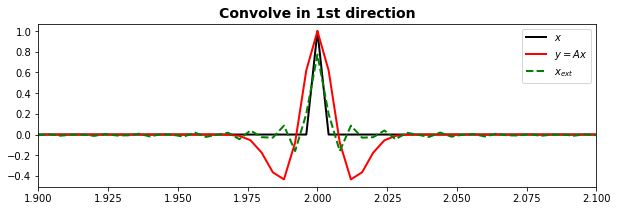

In [16]:
nt = 1001
dt = 0.004
t  = np.arange(nt)*dt
x  = np.zeros(nt)
x[int(nt/2)] = 1

h, th, hcenter = ricker(t[:101], f0=30)
    
Cop = Convolve1D(nt, h=h, offset=hcenter, dtype='float32')
dottest(Cop, nt, nt, verb=True)

y    = Cop*x

xlsqr, istop, itn, r1norm, r2norm = lsqr(Cop, y, damp=0, iter_lim=1000, show=0)[0:5]

fig, ax = plt.subplots(1,1,figsize=(10,3))
ax.plot(t, x,'k'      ,lw=2, label=r'$x$')
ax.plot(t, y,'r'      ,lw=2, label=r'$y=Ax$')
ax.plot(t, xlsqr,'--g',lw=2, label=r'$x_{ext}$')
ax.set_title('Convolve in 1st direction',fontsize=14, fontweight='bold')
ax.legend();
ax.set_xlim(1.9,2.1);

We take now a non-zero wavelet (not centered at its peak)

Dot test passed, v^T(Opu)=-48.941897 - u^T(Op^Tv)=-48.941897


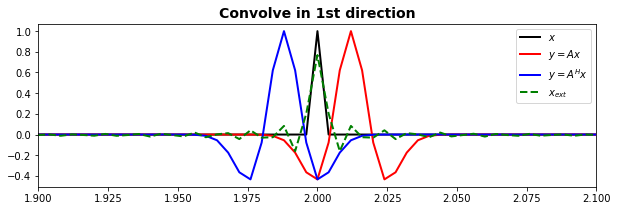

In [17]:
nt = 1001
dt = 0.004
t  = np.arange(nt)*dt
x  = np.zeros(nt)
x[int(nt/2)] = 1

h, th, hcenter = ricker(t[:101], f0=30)

Cop = Convolve1D(nt, h=h, offset=hcenter-3, dtype='float32')
dottest(Cop, nt, nt, verb=True)

y    = Cop*x
y1   = Cop.H*x


xlsqr, istop, itn, r1norm, r2norm = lsqr(Cop, y, damp=0, iter_lim=1000, show=0)[0:5]

fig, ax = plt.subplots(1,1,figsize=(10,3))
ax.plot(t, x, 'k'      ,lw=2, label=r'$x$')
ax.plot(t, y, 'r'      ,lw=2, label=r'$y=Ax$')
ax.plot(t, y1,'b'      ,lw=2, label=r'$y=A^Hx$')
ax.plot(t, xlsqr,'--g',lw=2, label=r'$x_{ext}$')
ax.set_title('Convolve in 1st direction',fontsize=14, fontweight='bold')
ax.legend();
ax.set_xlim(1.9,2.1);

We use a sparse solver to see if we can remove the side lobes

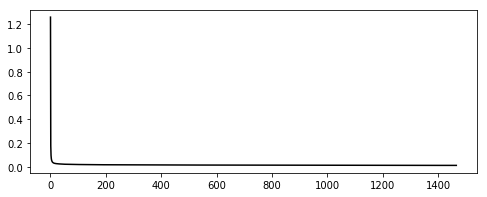

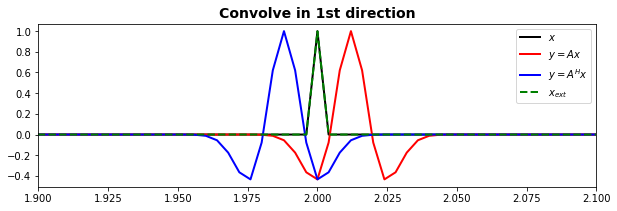

In [18]:
xista, niter, cost = ISTA(Cop, y, niter=10000, eps=0.01, alpha=0.1, returninfo=True)

plt.figure(figsize=(8, 3))
plt.plot(cost, 'k')

fig, ax = plt.subplots(1,1,figsize=(10,3))
ax.plot(t, x, 'k'      ,lw=2, label=r'$x$')
ax.plot(t, y, 'r'      ,lw=2, label=r'$y=Ax$')
ax.plot(t, y1,'b'      ,lw=2, label=r'$y=A^Hx$')
ax.plot(t, xista,'--g',lw=2, label=r'$x_{ext}$')
ax.set_title('Convolve in 1st direction',fontsize=14, fontweight='bold')
ax.legend();
ax.set_xlim(1.9,2.1);

Let's now have multiple events and compare LS and sparse solver

Dot test passed, v^T(Opu)=25.089899 - u^T(Op^Tv)=25.089899
iters: 300


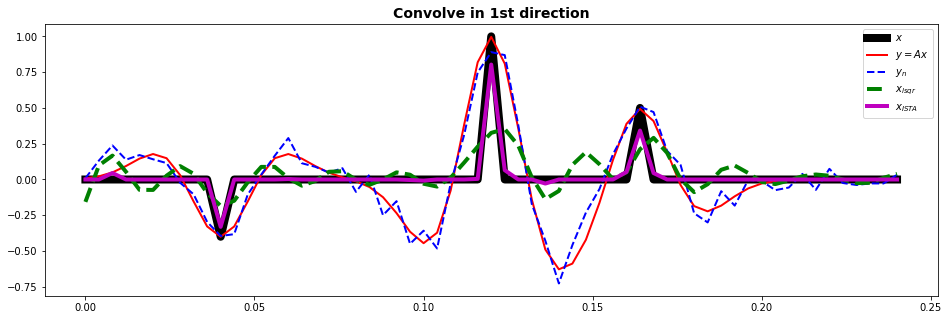

In [19]:
nt = 61
dt = 0.004
t  = np.arange(nt)*dt
x  = np.zeros(nt)
x[10] = -.4
x[int(nt/2)] = 1
x[nt-20] = 0.5

h, th, hcenter = ricker(t[:101], f0=20)
    
Cop = Convolve1D(nt, h=h, offset=hcenter, dtype='float32')
dottest(Cop, nt, nt, verb=True)

y    = Cop*x
yn = y + np.random.normal(0, 0.08, y.shape)

#xlsqr, istop, itn, r1norm, r2norm = lsqr(Cop, yn, damp=1e-1, atol=1e-3, iter_lim=100, show=0)[0:5]
xlsqr, istop, itn, r1norm, r2norm = RegularizedInversion(Cop, [], yn,
                                                          returninfo=True,
                                                          **dict(damp=1e-1, atol=1e-3, 
                                                                 iter_lim=100, show=0))

xista, niter, cost = ISTA(Cop, yn, niter=300, eps=5e-1, tol=1e-8, returninfo=True)
print('iters:', niter)

fig, ax = plt.subplots(1,1,figsize=(16,5))
ax.plot(t, x,'k'      ,lw=8, label=r'$x$')
ax.plot(t, y,'r'      ,lw=2, label=r'$y=Ax$')
ax.plot(t, yn,'--b'      ,lw=2, label=r'$y_n$')
ax.plot(t, xlsqr,'--g',lw=4, label=r'$x_{lsqr}$')
ax.plot(t, xista,'m',lw=4, label=r'$x_{ISTA}$')

ax.set_title('Convolve in 1st direction',fontsize=14, fontweight='bold')
ax.legend();

Let's now consider a 2d signal

Dot test passed, v^T(Opu)=26.413808 - u^T(Op^Tv)=26.413808


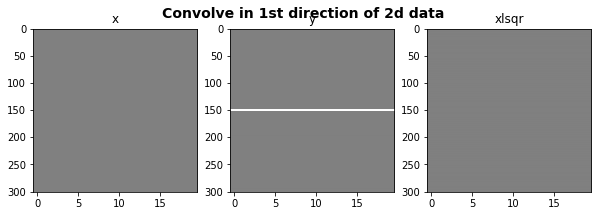

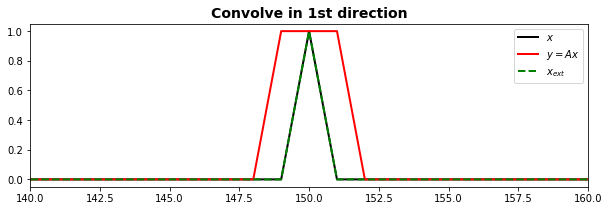

In [20]:
nt = 301
nx = 20
dt = 0.004
t  = np.arange(nt)*dt
x  = np.zeros((nt, nx))
x[int(nt/2),:] = 1

h = np.ones(3)
hcenter=1

Cop = Convolve1D(nt*nx, h=h, offset=hcenter, dims=[nt,nx], dir=0, dtype='float32')
dottest(Cop, nt*nx, nt*nx, verb=True)

y    = Cop*x.flatten()

xlsqr, istop, itn, r1norm, r2norm = lsqr(Cop, y, damp=0, iter_lim=1000, show=0)[0:5]

y = y.reshape(nt,nx)
xlsqr = xlsqr.reshape(nt,nx)

fig, axs = plt.subplots(1,3,figsize=(10,3))
fig.suptitle('Convolve in 1st direction of 2d data',fontsize=14, fontweight='bold')
axs[0].imshow(x, cmap='gray', vmin=-1, vmax=1)
axs[1].imshow(y, cmap='gray', vmin=-1, vmax=1)
axs[2].imshow(xlsqr, cmap='gray', vmin=-1, vmax=1)
axs[0].set_title('x'),axs[0].axis('tight')
axs[1].set_title('y'),axs[1].axis('tight')
axs[2].set_title('xlsqr'),axs[2].axis('tight');

fig, ax = plt.subplots(1,1,figsize=(10,3))
ax.plot(x[:, int(nx/2)],'k'      ,lw=2, label=r'$x$')
ax.plot(y[:, int(nx/2)],'r'      ,lw=2, label=r'$y=Ax$')
ax.plot(xlsqr[:, int(nx/2)],'--g',lw=2, label=r'$x_{ext}$')
ax.set_title('Convolve in 1st direction',fontsize=14, fontweight='bold')
ax.legend();
ax.set_xlim(140,160);

In [21]:
Cop_old = Convolve1D_old(nt*nx, h=h, offset=hcenter, dims=[nt,nx], dir=0, dtype='float32')

%timeit -n 100 -r 3 Cop._matvec(x.flatten())
%timeit -n 100 -r 3 Cop_old._matvec(x.flatten())

%timeit -n 100 -r 3 Cop._rmatvec(x.flatten())
%timeit -n 100 -r 3 Cop_old._rmatvec(x.flatten())

488 µs ± 12.2 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)
1.12 ms ± 63 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)
489 µs ± 35.3 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)
1.56 ms ± 337 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)


And with convolution over second axis

Dot test passed, v^T(Opu)=99.312864 - u^T(Op^Tv)=99.312864


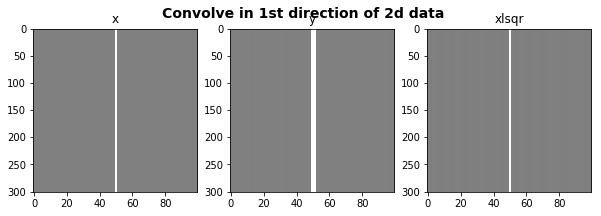

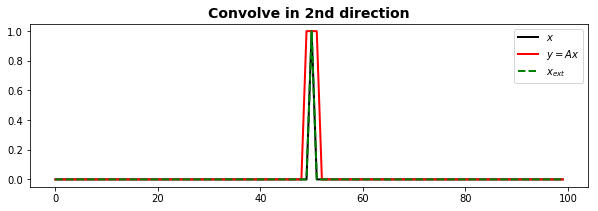

In [22]:
nt = 301
nx = 100
dt = 0.004
t  = np.arange(nt)*dt
x  = np.zeros((nt, nx))
x[:, int(nx/2)] = 1

h = np.ones(3)
hcenter=1

Cop = Convolve1D(nt*nx, h=h, offset=hcenter, dims=[nt,nx], dir=-1, dtype='float32')
dottest(Cop, nt*nx, nt*nx, verb=True)

y    = Cop*x.flatten()

xlsqr, istop, itn, r1norm, r2norm = lsqr(Cop, y, damp=0, iter_lim=1000, show=0)[0:5]

y = y.reshape(nt,nx)
xlsqr = xlsqr.reshape(nt,nx)

fig, axs = plt.subplots(1,3,figsize=(10,3))
fig.suptitle('Convolve in 1st direction of 2d data',fontsize=14, fontweight='bold')
axs[0].imshow(x, cmap='gray', vmin=-1, vmax=1)
axs[1].imshow(y, cmap='gray', vmin=-1, vmax=1)
axs[2].imshow(xlsqr, cmap='gray', vmin=-1, vmax=1)
axs[0].set_title('x'),axs[0].axis('tight')
axs[1].set_title('y'),axs[1].axis('tight')
axs[2].set_title('xlsqr'),axs[2].axis('tight');

fig, ax = plt.subplots(1,1,figsize=(10,3))
ax.plot(x[int(nt/2)],'k'      ,lw=2, label=r'$x$')
ax.plot(y[int(nt/2)],'r'      ,lw=2, label=r'$y=Ax$')
ax.plot(xlsqr[int(nt/2)],'--g',lw=2, label=r'$x_{ext}$')
ax.set_title('Convolve in 2nd direction',fontsize=14, fontweight='bold')
ax.legend();

In [23]:
Cop_old = Convolve1D_old(nt*nx, h=h, offset=hcenter, dims=[nt, nx], dir=-1, dtype='float32')

%timeit -n 100 -r 3 Cop._matvec(x.flatten())
%timeit -n 100 -r 3 Cop_old._matvec(x.flatten())

%timeit -n 100 -r 3 Cop._rmatvec(x.flatten())
%timeit -n 100 -r 3 Cop_old._rmatvec(x.flatten())

1.95 ms ± 243 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)
6.47 ms ± 2.16 ms per loop (mean ± std. dev. of 3 runs, 100 loops each)
1.98 ms ± 333 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)
6.15 ms ± 521 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)


## 2d Convolution

We want now to create an operator that applies convolution with a kernel $k(t)$ to the input signal $x(t)$:

$$y(t,x) = \int_{-\inf}^{\inf}\int_{-\inf}^{\inf} h(t-\tau,x-\chi) x(\tau,\chi) d\tau d\chi $$

This operation can be discretized as follows

$$y[i,n] = \sum_{j=-\inf}^{\inf} \sum_{m=-\inf}^{\inf} h[i-j,n-m] x[j,m] $$

and performed by means of a linear operator

$$\mathbf{y}= \mathbf{C}_2 \mathbf{x}$$

Let's apply 2d convolution on 2d signal

Dot test passed, v^T(Opu)=-120.244132 - u^T(Op^Tv)=-120.244132


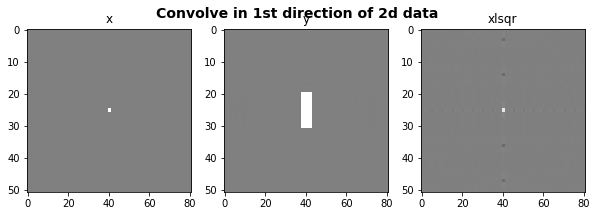

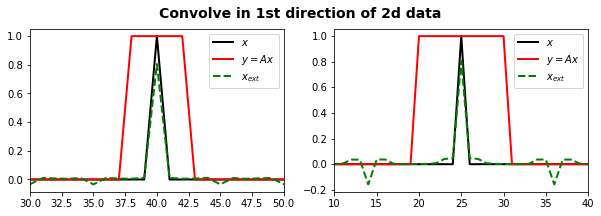

In [24]:
nt = 51
nx = 81
dt = 0.004
t  = np.arange(nt)*dt
x  = np.zeros((nt,nx))
x[int(nt/2),int(nx/2)] = 1

nh = [11,5]
h  = np.ones((nh[0], nh[1]))

Cop = Convolve2D(nt*nx, h=h, offset=[int(nh[0])/2,int(nh[1])/2], 
                 dims=[nt,nx], dtype='float32')
dottest(Cop, nt*nx, nt*nx, verb=True)

y    = Cop*x.flatten()

xlsqr, istop, itn, r1norm, r2norm = lsqr(Cop, y, damp=0, iter_lim=500, show=0)[0:5]

y = y.reshape(nt,nx)
xlsqr = xlsqr.reshape(nt,nx)

fig, axs = plt.subplots(1,3,figsize=(10,3))
fig.suptitle('Convolve in 1st direction of 2d data',fontsize=14, fontweight='bold')
axs[0].imshow(x, cmap='gray', vmin=-1, vmax=1)
axs[1].imshow(y, cmap='gray', vmin=-1, vmax=1)
axs[2].imshow(xlsqr, cmap='gray', vmin=-1, vmax=1)
axs[0].set_title('x'),axs[0].axis('tight')
axs[1].set_title('y'),axs[1].axis('tight')
axs[2].set_title('xlsqr'),axs[2].axis('tight');

fig, ax = plt.subplots(1,2,figsize=(10,3))
fig.suptitle('Convolve in 1st direction of 2d data',fontsize=14, fontweight='bold')
ax[0].plot(x[int(nt/2), :],'k'      ,lw=2, label=r'$x$')
ax[0].plot(y[int(nt/2), :],'r'      ,lw=2, label=r'$y=Ax$')
ax[0].plot(xlsqr[int(nt/2), :],'--g',lw=2, label=r'$x_{ext}$')
ax[1].plot(x[:, int(nx/2)],'k'      ,lw=2, label=r'$x$')
ax[1].plot(y[:, int(nx/2)],'r'      ,lw=2, label=r'$y=Ax$')
ax[1].plot(xlsqr[:, int(nx/2)],'--g',lw=2, label=r'$x_{ext}$')
ax[0].legend();
ax[0].set_xlim(30,50);
ax[1].legend();
ax[1].set_xlim(10,40);

Same but with non-zero phase signal

Dot test passed, v^T(Opu)=-227.720072 - u^T(Op^Tv)=-227.720072


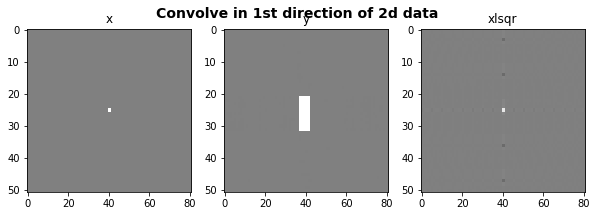

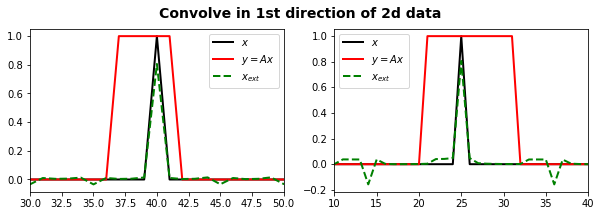

In [25]:
nt = 51
nx = 81
dt = 0.004
t  = np.arange(nt)*dt
x  = np.zeros((nt,nx))
x[int(nt/2),int(nx/2)] = 1

nh = [11,5]
h  = np.ones((nh[0],nh[1]))

Cop = Convolve2D(nt*nx, h=h, offset=[int(nh[0])/2-1,int(nh[1])/2+1], 
                 dims=[nt,nx], dtype='float32', method='fft')
dottest(Cop, nt*nx, nt*nx, verb=True)

y    = Cop*x.flatten()

xlsqr, istop, itn, r1norm, r2norm = lsqr(Cop, y, damp=0, iter_lim=500, show=0)[0:5]

y = y.reshape(nt,nx)
xlsqr = xlsqr.reshape(nt,nx)

fig, axs = plt.subplots(1,3,figsize=(10,3))
fig.suptitle('Convolve in 1st direction of 2d data',fontsize=14, fontweight='bold')
axs[0].imshow(x, cmap='gray', vmin=-1, vmax=1)
axs[1].imshow(y, cmap='gray', vmin=-1, vmax=1)
axs[2].imshow(xlsqr, cmap='gray', vmin=-1, vmax=1)
axs[0].set_title('x'),axs[0].axis('tight')
axs[1].set_title('y'),axs[1].axis('tight')
axs[2].set_title('xlsqr'),axs[2].axis('tight');

fig, ax = plt.subplots(1,2,figsize=(10,3))
fig.suptitle('Convolve in 1st direction of 2d data',fontsize=14, fontweight='bold')
ax[0].plot(x[int(nt/2), :],'k'      ,lw=2, label=r'$x$')
ax[0].plot(y[int(nt/2), :],'r'      ,lw=2, label=r'$y=Ax$')
ax[0].plot(xlsqr[int(nt/2), :],'--g',lw=2, label=r'$x_{ext}$')
ax[1].plot(x[:, int(nx/2)],'k'      ,lw=2, label=r'$x$')
ax[1].plot(y[:, int(nx/2)],'r'      ,lw=2, label=r'$y=Ax$')
ax[1].plot(xlsqr[:, int(nx/2)],'--g',lw=2, label=r'$x_{ext}$')
ax[0].legend();
ax[0].set_xlim(30,50);
ax[1].legend();
ax[1].set_xlim(10,40);

In [26]:
Cop_old = Convolve2D_old(nt*nx, h=h, offset=[int(nh[0])/2-1,int(nh[1])/2+1], 
                         dims=[nt,nx], dtype='float32')

%timeit -n 100 -r 3 Cop._matvec(x.flatten())
%timeit -n 100 -r 3 Cop_old._matvec(x.flatten())

%timeit -n 100 -r 3 Cop._rmatvec(x.flatten())
%timeit -n 100 -r 3 Cop_old._rmatvec(x.flatten())

1.19 ms ± 293 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)
2.05 ms ± 165 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)
913 µs ± 175 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)
1.86 ms ± 248 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)


We do the same with a oscillating filter

Dot test passed, v^T(Opu)=339.014334 - u^T(Op^Tv)=339.014334


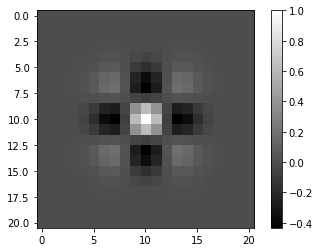

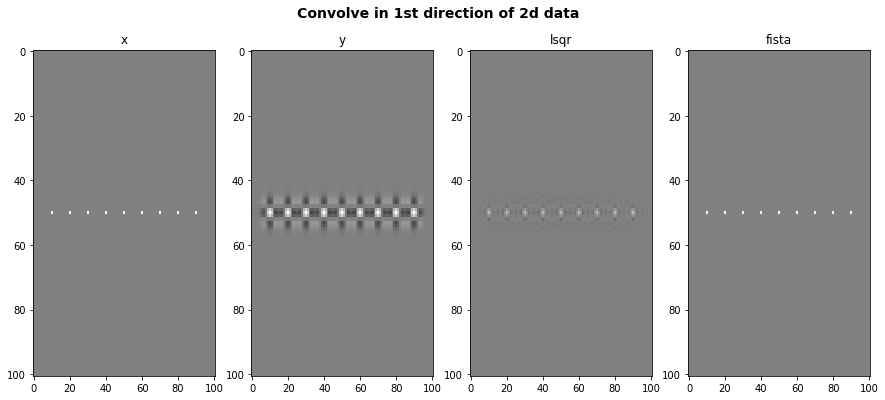

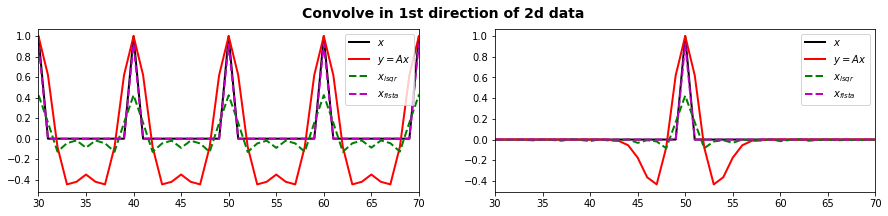

In [27]:
# create 2d wavelet
nt = 31
dt = 0.004
t  = np.arange(nt)*dt
h, th, hcenter = ricker(t, f0=30)

imp = np.zeros((21, 21))
imp[10, 10] = 1
imp = fftconvolve(imp, h[:, np.newaxis], mode='same', axes=0)
imp = fftconvolve(imp, h[np.newaxis, :], mode='same', axes=1)

plt.figure()
plt.imshow(imp, cmap='gray')
plt.colorbar()

nt = 101
nx = 101
x = np.zeros((nt,nx))
x[int(nt/2), 10:-10:10] = 1

Cop = Convolve2D(nt*nx, h=imp, offset=[imp.shape[0]//2, imp.shape[1]//2], 
                 dims=[nt,nx], dtype='float32')
dottest(Cop, nt*nx, nt*nx, verb=True)
y    = Cop*x.flatten()

xlsqr, istop, itn, r1norm, r2norm = lsqr(Cop, y, damp=0, iter_lim=500, show=0)[0:5]
xfista = FISTA(Cop, y, eps=1e0, niter=200, show=0)[0]

y = y.reshape(nt,nx)
xlsqr = xlsqr.reshape(nt,nx)
xfista = xfista.reshape(nt,nx)

fig, axs = plt.subplots(1,4,figsize=(15,6))
fig.suptitle('Convolve in 1st direction of 2d data',fontsize=14, fontweight='bold')
axs[0].imshow(x, cmap='gray', vmin=-1, vmax=1)
axs[1].imshow(y, cmap='gray', vmin=-1, vmax=1)
axs[2].imshow(xlsqr, cmap='gray', vmin=-1, vmax=1)
axs[3].imshow(xfista, cmap='gray', vmin=-1, vmax=1)
axs[0].set_title('x'),axs[0].axis('tight')
axs[1].set_title('y'),axs[1].axis('tight')
axs[2].set_title('lsqr'),axs[2].axis('tight');
axs[3].set_title('fista'),axs[3].axis('tight');

fig, ax = plt.subplots(1,2,figsize=(15,3))
fig.suptitle('Convolve in 1st direction of 2d data',fontsize=14, fontweight='bold')
ax[0].plot(x[int(nt/2), :],'k'      ,lw=2, label=r'$x$')
ax[0].plot(y[int(nt/2), :],'r'      ,lw=2, label=r'$y=Ax$')
ax[0].plot(xlsqr[int(nt/2), :],'--g',lw=2, label=r'$x_{lsqr}$')
ax[0].plot(xfista[int(nt/2), :],'--m',lw=2, label=r'$x_{fista}$')
ax[1].plot(x[:, int(nx/2)],'k'      ,lw=2, label=r'$x$')
ax[1].plot(y[:, int(nx/2)],'r'      ,lw=2, label=r'$y=Ax$')
ax[1].plot(xlsqr[:, int(nx/2)],'--g',lw=2, label=r'$x_{lsqr}$')
ax[1].plot(xfista[:, int(nx/2)],'--m',lw=2, label=r'$x_{fista}$')
ax[0].legend();
ax[0].set_xlim(30,70);
ax[1].legend();
ax[1].set_xlim(30,70);

Let's finally apply 2d convolution on 3d signal (convolution is applied to 1st and 2nd directions)

Dot test passed, v^T(Opu)=1321.593256 - u^T(Op^Tv)=1321.593256


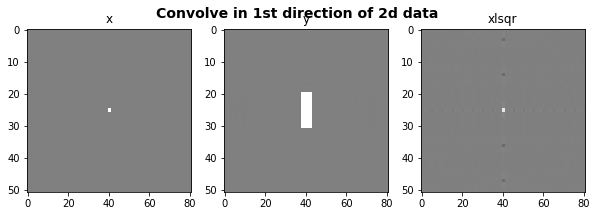

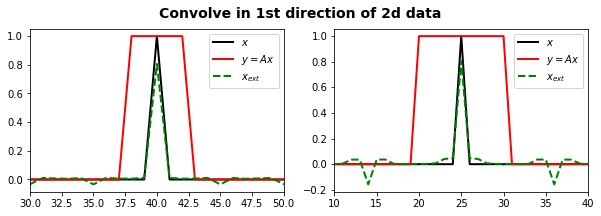

In [28]:
nt = 51
nx = 81
ny = 11
dt = 0.004
t  = np.arange(nt)*dt
x  = np.zeros((nt, nx, ny))
x[int(nt/2), int(nx/2), int(ny/2)] = 1

nh = [11,5]
h  = np.ones((nh[0], nh[1]))

Cop = Convolve2D(nt*nx*ny, h=h, offset=[int(nh[0])/2,int(nh[1])/2], 
                 dims=[nt,nx,ny], nodir=2, dtype='float32')
dottest(Cop, nt*nx*ny, nt*nx*ny, verb=True)

y    = Cop*x.flatten()

xlsqr, istop, itn, r1norm, r2norm = lsqr(Cop, y, damp=0, iter_lim=500, show=0)[0:5]

y = y.reshape(nt,nx,ny)
xlsqr = xlsqr.reshape(nt,nx,ny)

fig, axs = plt.subplots(1,3,figsize=(10,3))
fig.suptitle('Convolve in 1st direction of 2d data',fontsize=14, fontweight='bold')
axs[0].imshow(x[:, :, int(ny/2)], cmap='gray', vmin=-1, vmax=1)
axs[1].imshow(y[:, :, int(ny/2)], cmap='gray', vmin=-1, vmax=1)
axs[2].imshow(xlsqr[:, :, int(ny/2)], cmap='gray', vmin=-1, vmax=1)
axs[0].set_title('x'), axs[0].axis('tight')
axs[1].set_title('y'), axs[1].axis('tight')
axs[2].set_title('xlsqr'), axs[2].axis('tight');

fig, ax = plt.subplots(1,2,figsize=(10,3))
fig.suptitle('Convolve in 1st direction of 2d data',fontsize=14, fontweight='bold')
ax[0].plot(x[int(nt/2), :, int(ny/2)],'k'      ,lw=2, label=r'$x$')
ax[0].plot(y[int(nt/2), :, int(ny/2)],'r'      ,lw=2, label=r'$y=Ax$')
ax[0].plot(xlsqr[int(nt/2), :, int(ny/2)],'--g',lw=2, label=r'$x_{ext}$')
ax[1].plot(x[:, int(nx/2), int(ny/2)],'k'      ,lw=2, label=r'$x$')
ax[1].plot(y[:, int(nx/2), int(ny/2)],'r'      ,lw=2, label=r'$y=Ax$')
ax[1].plot(xlsqr[:, int(nx/2), int(ny/2)],'--g',lw=2, label=r'$x_{ext}$')
ax[0].legend();
ax[0].set_xlim(30,50);
ax[1].legend();
ax[1].set_xlim(10,40);

In [29]:
Cop_old = Convolve2D_old(nt*nx*ny, h=h, 
                         offset=[int(nh[0])/2, int(nh[1])/2], 
                         dims=[nt,nx,ny], nodir=2, dtype='float32')
Cop_nd = ConvolveND(nt*nx*ny, h=h, 
                    offset=[int(nh[0])/2, int(nh[1])/2], 
                    dims=[nt,nx,ny], dirs=[0,1], 
                    dtype='float32')

y = Cop._matvec(x.flatten())
yold = Cop_old._matvec(x.flatten())
ynd = Cop_nd._matvec(x.flatten())

xadj = Cop._matvec(x.flatten())
xadjold = Cop_old._matvec(x.flatten())
xadjnd = Cop_nd._matvec(x.flatten())

print(np.allclose(y, ynd))
print(np.allclose(xadj, xadjnd))
print(np.allclose(y, yold))
print(np.allclose(xadj, xadjold))

%timeit -n 100 -r 3 Cop._matvec(x.flatten())
%timeit -n 100 -r 3 Cop_old._matvec(x.flatten())
%timeit -n 100 -r 3 Cop_nd._matvec(x.flatten())

%timeit -n 100 -r 3 Cop._rmatvec(x.flatten())
%timeit -n 100 -r 3 Cop_old._rmatvec(x.flatten())
%timeit -n 100 -r 3 Cop_nd._rmatvec(x.flatten())

True
True
True
True
7.68 ms ± 1.63 ms per loop (mean ± std. dev. of 3 runs, 100 loops each)
37.5 ms ± 6.47 ms per loop (mean ± std. dev. of 3 runs, 100 loops each)
6.71 ms ± 691 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)
6.18 ms ± 485 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)
23.3 ms ± 1.3 ms per loop (mean ± std. dev. of 3 runs, 100 loops each)
6.71 ms ± 456 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)


## Nd Convolution

Extension of two previous operators to N>2 dimensions

Dot test passed, v^T(Opu)=550.275824 - u^T(Op^Tv)=550.275824


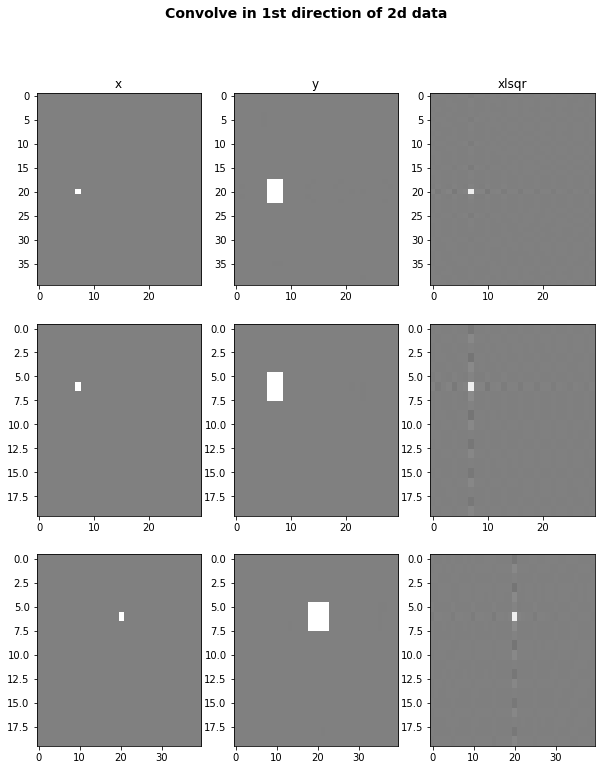

In [30]:
ny, nx, nz = 20, 40, 30
x = np.zeros((ny, nx, nz))
x[ny//3, nx//2, nz//4] = 1
h = np.ones((3, 5, 3))
offset = [1, 2, 1]

Cop = ConvolveND(nx*ny*nz, h=h, offset=offset, 
                 dims=[ny, nx, nz], dirs=[0,1,2], dtype='float32')
dottest(Cop, ny*nx*nz, ny*nx*nz, verb=True)

y    = Cop*x.flatten()
xlsqr, istop, itn, r1norm, r2norm = \
    lsqr(Cop, y, damp=0, iter_lim=500, show=0)[0:5]

y = y.reshape(ny, nx, nz)
xlsqr = xlsqr.reshape(ny, nx, nz)

fig, axs = plt.subplots(3,3,figsize=(10, 12))
fig.suptitle('Convolve in 1st direction of 2d data',fontsize=14, fontweight='bold')
axs[0][0].imshow(x[ny//3], cmap='gray', vmin=-1, vmax=1)
axs[0][1].imshow(y[ny//3], cmap='gray', vmin=-1, vmax=1)
axs[0][2].imshow(xlsqr[ny//3], cmap='gray', vmin=-1, vmax=1)
axs[0][0].set_title('x')
axs[0][0].axis('tight')
axs[0][1].set_title('y')
axs[0][1].axis('tight')
axs[0][2].set_title('xlsqr')
axs[0][2].axis('tight')
axs[1][0].imshow(x[:, nx//2], cmap='gray', vmin=-1, vmax=1)
axs[1][1].imshow(y[:, nx//2], cmap='gray', vmin=-1, vmax=1)
axs[1][2].imshow(xlsqr[:, nx//2], cmap='gray', vmin=-1, vmax=1)
axs[1][0].axis('tight')
axs[1][1].axis('tight')
axs[1][2].axis('tight');
axs[2][0].imshow(x[..., nz//4], cmap='gray', vmin=-1, vmax=1)
axs[2][1].imshow(y[..., nz//4], cmap='gray', vmin=-1, vmax=1)
axs[2][2].imshow(xlsqr[..., nz//4], cmap='gray', vmin=-1, vmax=1)
axs[2][0].axis('tight')
axs[2][1].axis('tight')
axs[2][2].axis('tight');

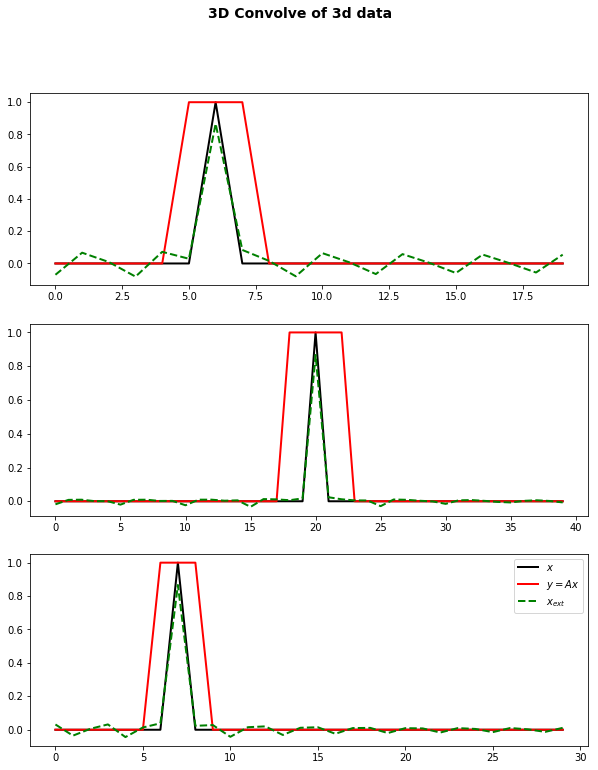

In [31]:
fig, ax = plt.subplots(3,1, figsize=(10,12))
fig.suptitle('3D Convolve of 3d data',fontsize=14, fontweight='bold')
ax[0].plot(x[:, nx//2, nz//4],'k'      ,lw=2, label=r'$x$')
ax[0].plot(y[:, nx//2, nz//4],'r'      ,lw=2, label=r'$y=Ax$')
ax[0].plot(xlsqr[:, nx//2, nz//4],'--g',lw=2, label=r'$x_{ext}$')
ax[1].plot(x[ny//3, :, nz//4],'k'      ,lw=2, label=r'$x$')
ax[1].plot(y[ny//3, :, nz//4],'r'      ,lw=2, label=r'$y=Ax$')
ax[1].plot(xlsqr[ny//3, :, nz//4],'--g',lw=2, label=r'$x_{ext}$')
ax[2].plot(x[ny//3, nx//2], 'k', lw=2, label=r'$x$')
ax[2].plot(y[ny//3, nx//2], 'r', lw=2, label=r'$y=Ax$')
ax[2].plot(xlsqr[ny//3, nx//2],'--g',lw=2, label=r'$x_{ext}$')
ax[2].legend();

In [32]:
Cop = ConvolveND(nx*ny*nz, h=h, offset=offset, 
                 dims=[ny, nx, nz], dirs=[0,1,2], dtype='float32')
Cop1 = ConvolveND(nx*ny*nz, h=h, offset=offset, 
                  dims=[ny, nx, nz], dirs=[0,1,2], 
                  method='fft', dtype='float32')

%timeit -n 10 -r 3 Cop._matvec(x.flatten())
%timeit -n 10 -r 3 Cop1._matvec(x.flatten())

%timeit -n 10 -r 3 Cop._rmatvec(x.flatten())
%timeit -n 10 -r 3 Cop1._rmatvec(x.flatten())

12.8 ms ± 3.12 ms per loop (mean ± std. dev. of 3 runs, 10 loops each)
14.7 ms ± 876 µs per loop (mean ± std. dev. of 3 runs, 10 loops each)
8.79 ms ± 988 µs per loop (mean ± std. dev. of 3 runs, 10 loops each)
8.62 ms ± 625 µs per loop (mean ± std. dev. of 3 runs, 10 loops each)


And with non-zero phase filter

Dot test passed, v^T(Opu)=1752.268370 - u^T(Op^Tv)=1752.268370


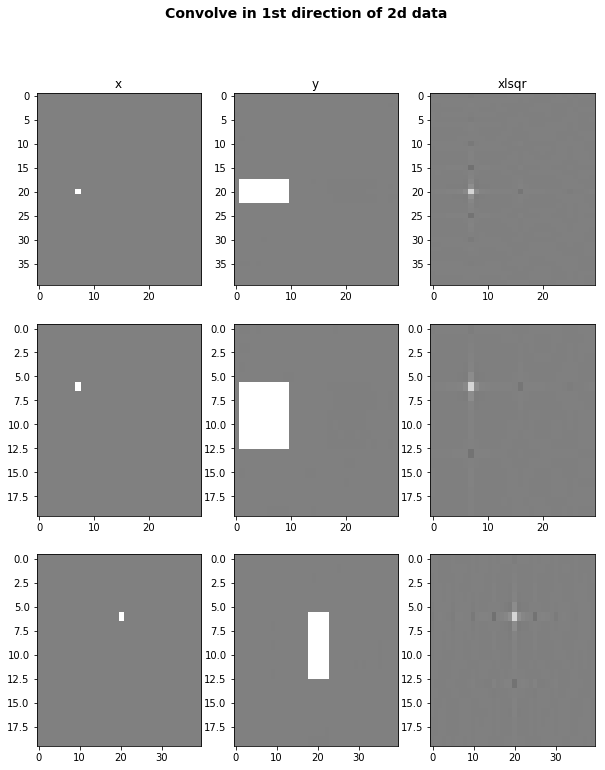

In [33]:
ny, nx, nz = 20, 40, 30
x = np.zeros((ny, nx, nz))
x[ny//3, nx//2, nz//4] = 1
h = np.ones((7, 5, 9))
offset = [0, 2, 6]

Cop = ConvolveND(nx*ny*nz, h=h, offset=offset, 
                 dims=[ny, nx, nz], dirs=None, dtype='float32')
dottest(Cop, ny*nx*nz, ny*nx*nz, verb=True)

y = Cop*x.flatten()
xlsqr, istop, itn, r1norm, r2norm = \
    lsqr(Cop, y, damp=0, iter_lim=300, show=0)[0:5]

y = y.reshape(ny, nx, nz)
xlsqr = xlsqr.reshape(ny, nx, nz)

fig, axs = plt.subplots(3,3,figsize=(10, 12))
fig.suptitle('Convolve in 1st direction of 2d data',fontsize=14, fontweight='bold')
axs[0][0].imshow(x[ny//3], cmap='gray', vmin=-1, vmax=1)
axs[0][1].imshow(y[ny//3], cmap='gray', vmin=-1, vmax=1)
axs[0][2].imshow(xlsqr[ny//3], cmap='gray', vmin=-1, vmax=1)
axs[0][0].set_title('x')
axs[0][0].axis('tight')
axs[0][1].set_title('y')
axs[0][1].axis('tight')
axs[0][2].set_title('xlsqr')
axs[0][2].axis('tight')
axs[1][0].imshow(x[:, nx//2], cmap='gray', vmin=-1, vmax=1)
axs[1][1].imshow(y[:, nx//2], cmap='gray', vmin=-1, vmax=1)
axs[1][2].imshow(xlsqr[:, nx//2], cmap='gray', vmin=-1, vmax=1)
axs[1][0].axis('tight')
axs[1][1].axis('tight')
axs[1][2].axis('tight');
axs[2][0].imshow(x[..., nz//4], cmap='gray', vmin=-1, vmax=1)
axs[2][1].imshow(y[..., nz//4], cmap='gray', vmin=-1, vmax=1)
axs[2][2].imshow(xlsqr[..., nz//4], cmap='gray', vmin=-1, vmax=1)
axs[2][0].axis('tight')
axs[2][1].axis('tight')
axs[2][2].axis('tight');

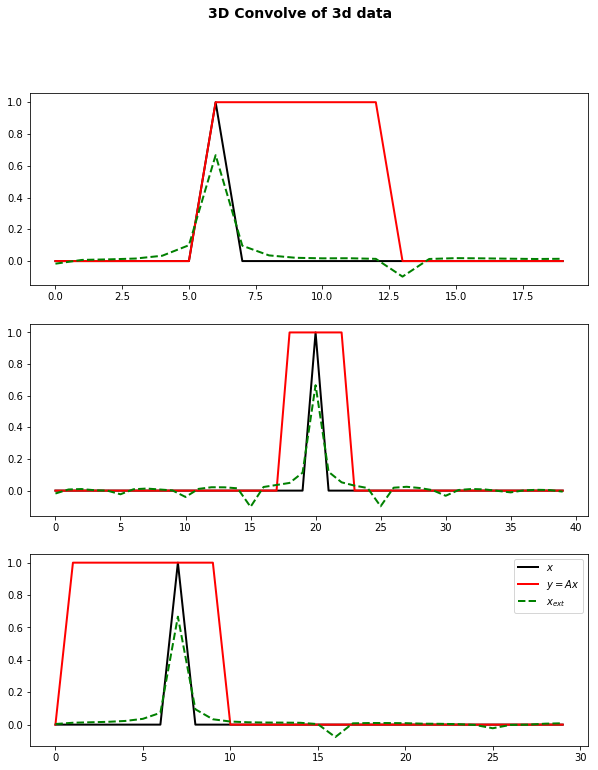

In [34]:
fig, ax = plt.subplots(3,1, figsize=(10,12))
fig.suptitle('3D Convolve of 3d data',fontsize=14, fontweight='bold')
ax[0].plot(x[:, nx//2, nz//4],'k'      ,lw=2, label=r'$x$')
ax[0].plot(y[:, nx//2, nz//4],'r'      ,lw=2, label=r'$y=Ax$')
ax[0].plot(xlsqr[:, nx//2, nz//4],'--g',lw=2, label=r'$x_{ext}$')
ax[1].plot(x[ny//3, :, nz//4],'k'      ,lw=2, label=r'$x$')
ax[1].plot(y[ny//3, :, nz//4],'r'      ,lw=2, label=r'$y=Ax$')
ax[1].plot(xlsqr[ny//3, :, nz//4],'--g',lw=2, label=r'$x_{ext}$')
ax[2].plot(x[ny//3, nx//2], 'k', lw=2, label=r'$x$')
ax[2].plot(y[ny//3, nx//2], 'r', lw=2, label=r'$y=Ax$')
ax[2].plot(xlsqr[ny//3, nx//2],'--g',lw=2, label=r'$x_{ext}$')
ax[2].legend();

Finally we do the same with oscillating filter

Dot test passed, v^T(Opu)=158.938567 - u^T(Op^Tv)=158.938567


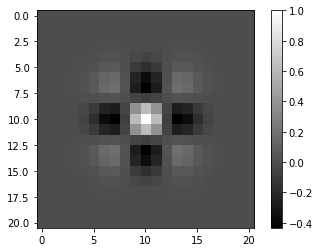

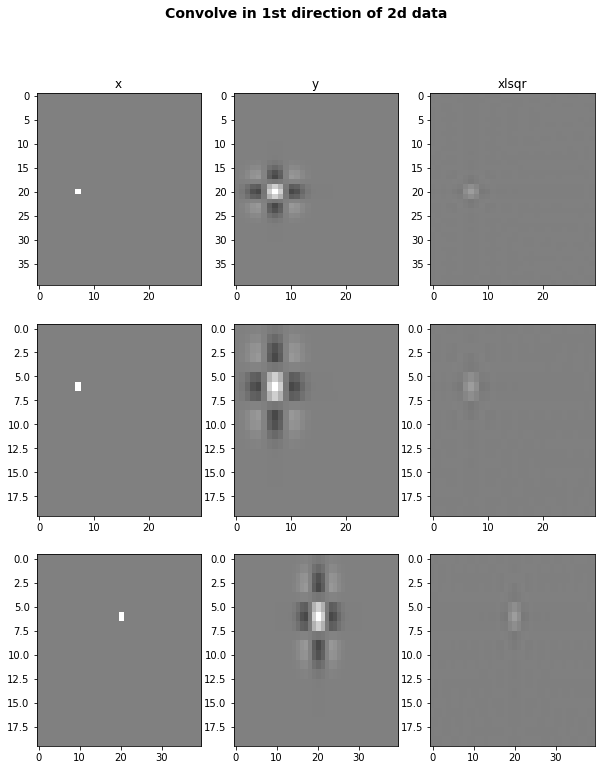

In [35]:
# create 2d wavelet
nt = 31
dt = 0.004
t  = np.arange(nt)*dt
h, th, hcenter = ricker(t, f0=30)

imp = np.zeros((21, 21, 21))
imp[10, 10, 10] = 1

imp = fftconvolve(imp, h[:, np.newaxis, np.newaxis], mode='same', axes=0)
imp = fftconvolve(imp, h[np.newaxis, :, np.newaxis], mode='same', axes=1)
imp = fftconvolve(imp, h[np.newaxis, np.newaxis, :], mode='same', axes=2)

plt.figure()
plt.imshow(imp[imp.shape[0]//2], cmap='gray')
plt.colorbar()

ny, nx, nz = 20, 40, 30
x = np.zeros((ny, nx, nz))
x[ny//3, nx//2, nz//4] = 1
h = np.ones((7, 5, 9))
offset = [10, 10, 10]

Cop = ConvolveND(nx*ny*nz, h=imp, offset=[imp.shape[0]//2, imp.shape[1]//2, imp.shape[2]//2], 
                 dims=[ny, nx, nz], dirs=None, dtype='float32')
dottest(Cop, ny*nx*nz, ny*nx*nz, verb=True)

y = Cop*x.flatten()
xlsqr, istop, itn, r1norm, r2norm = \
    lsqr(Cop, y, damp=0, iter_lim=300, show=0)[0:5]

y = y.reshape(ny, nx, nz)
xlsqr = xlsqr.reshape(ny, nx, nz)

fig, axs = plt.subplots(3,3,figsize=(10, 12))
fig.suptitle('Convolve in 1st direction of 2d data',fontsize=14, fontweight='bold')
axs[0][0].imshow(x[ny//3], cmap='gray', vmin=-1, vmax=1)
axs[0][1].imshow(y[ny//3], cmap='gray', vmin=-1, vmax=1)
axs[0][2].imshow(xlsqr[ny//3], cmap='gray', vmin=-1, vmax=1)
axs[0][0].set_title('x')
axs[0][0].axis('tight')
axs[0][1].set_title('y')
axs[0][1].axis('tight')
axs[0][2].set_title('xlsqr')
axs[0][2].axis('tight')
axs[1][0].imshow(x[:, nx//2], cmap='gray', vmin=-1, vmax=1)
axs[1][1].imshow(y[:, nx//2], cmap='gray', vmin=-1, vmax=1)
axs[1][2].imshow(xlsqr[:, nx//2], cmap='gray', vmin=-1, vmax=1)
axs[1][0].axis('tight')
axs[1][1].axis('tight')
axs[1][2].axis('tight')
axs[2][0].imshow(x[..., nz//4], cmap='gray', vmin=-1, vmax=1)
axs[2][1].imshow(y[..., nz//4], cmap='gray', vmin=-1, vmax=1)
axs[2][2].imshow(xlsqr[..., nz//4], cmap='gray', vmin=-1, vmax=1)
axs[2][0].axis('tight')
axs[2][1].axis('tight')
axs[2][2].axis('tight');